In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from functions.functions import *

In [2]:
def set_timestep(df_ts: object) -> object:
    df_ts['time'] = df_ts['time'].str[:19]
    df_ts['time'] = pd.to_datetime(df_ts['time'], format="%Y-%m-%dT%H:%M:%S")
    df_ts.set_index('time', inplace=True)
    return df_ts


def ABS_SHAP(df_shap, df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index() #.drop('index', axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i], df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns = ['Variable', 'Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0, 'red', 'blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable', 'SHAP_abs']
    k2 = k.merge(corr_df, left_on='Variable', right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs', ascending=True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable', y='SHAP_abs', color=colorlist, figsize=(5, 6), legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

In [4]:
# load GEOVARIABLES
df_grid = gpd.read_file(r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data\LandUseRegression\Pl_map\5km_all_wind_int_build.gpkg')
df_grid

Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.


,id,greenmean,tpi_mean,pop_sum,windmean,hex_id,intmean,build,geometry
0,768,0.059667,-0.207174,195834.0,3.150000,768,NaN,0.0,"POLYGON ((4595111.401 3321520.622, 4596230.346..."
1,769,0.002314,-0.338080,74820.0,3.250000,769,NaN,0.0,"POLYGON ((4595735.095 3316561.763, 4596854.210..."
2,770,0.184722,-0.137268,115946.0,3.200000,770,NaN,7.0,"POLYGON ((4596358.458 3311602.848, 4597477.743..."
3,771,0.000000,-0.231607,64332.0,3.200000,771,NaN,0.0,"POLYGON ((4596981.490 3306643.877, 4598100.946..."
4,881,0.000000,-0.164587,50605.0,3.179963,881,NaN,0.0,"POLYGON ((4598468.018 3329497.564, 4599586.744..."
...,...,...,...,...,...,...,...,...,...
14808,19418,0.038907,-0.009876,12323.0,3.300000,19418,NaN,200.0,"POLYGON ((5308729.679 3155574.837, 5309850.746..."
14809,19419,0.230236,-0.015500,28058.0,3.300000,19419,NaN,116.0,"POLYGON ((5309341.178 3150602.340, 5310462.365..."
14810,19420,0.016204,-0.053586,34234.0,3.300000,19420,NaN,151.0,"POLYGON ((5309952.446 3145629.838, 5311073.753..."
14811,19421,0.023644,-0.065356,27497.0,3.300000,19421,NaN,25.0,"POLYGON ((5310563.482 3140657.332, 5311684.909..."


In [50]:
df_data = pd.read_csv(r'g:\Mój dysk\DS_Reports\Raporty_PL\Onet_2021\data_master\FINAL_DATA\20210913T141800_data.csv')
df_data = set_timestep(df_data)
df_data_vars = df_data[['id', 'pm10', 'pm25']]

# select 3 winter months
df_data_winter = df_data_vars.loc[df_data_vars.index > '2020-12-01']
df_data_winter = df_data_winter.loc[df_data_winter.index < '2021-03-31']
df_data_winter = df_data_winter.loc[df_data_winter.pm25>0]

# groupby
df_data_winter_mean = df_data_winter.groupby('id').median()
df_data_winter_mean = df_data_winter_mean.dropna()
df_data_winter_mean = df_data_winter_mean.reset_index()

# data cleaning - outliers
df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean.pm25 > 1]
# df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean.temperature < 15]
# df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean.temperature > -10]
df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean.pm25 < 70]
df_data_winter_mean = df_data_winter_mean.reset_index()


In [51]:
# data period - only more than 75%
df_data_count = df_data_winter.groupby('id').count()

df_data_count = df_data_count.loc[df_data_count.pm25 > 100]
df_data_count = df_data_count.reset_index()

df_data_count_list = df_data_count['id'].unique()
print(df_data_winter_mean.shape[0])
df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean['id'].isin(df_data_count_list)]
print(df_data_winter_mean.shape[0])

3237
2658


<AxesSubplot:>

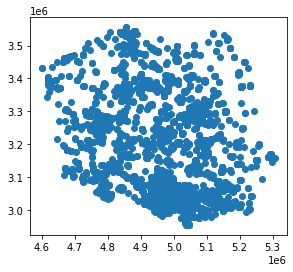

In [52]:
df_instas = pd.read_csv(r'g:\Mój dysk\DS_Reports\Raporty_PL\Onet_2021\data_master\FINAL_DATA\20210913T141800_installations.csv')

gdf_instas = make_gdf(df_instas, 'lng', 'lat', epsg_in='epsg:4326', epsg_out='epsg:3035')
# todo merge with gdf

gdf_data_winter_mean = pd.merge(gdf_instas, df_data_winter_mean, on='id', how='left')
gdf_data_winter_mean.plot()

,id,greenmean,tpi_mean,pop_sum,windmean,hex_id,intmean,build,geometry,pm25
0,768,0.059667,-0.207174,195834.0,3.150000,768,NaN,0.0,"POLYGON ((4595111.401 3321520.622, 4596230.346...",NaN
1,769,0.002314,-0.338080,74820.0,3.250000,769,NaN,0.0,"POLYGON ((4595735.095 3316561.763, 4596854.210...",NaN
2,770,0.184722,-0.137268,115946.0,3.200000,770,NaN,7.0,"POLYGON ((4596358.458 3311602.848, 4597477.743...",NaN
3,771,0.000000,-0.231607,64332.0,3.200000,771,NaN,0.0,"POLYGON ((4596981.490 3306643.877, 4598100.946...",NaN
4,881,0.000000,-0.164587,50605.0,3.179963,881,NaN,0.0,"POLYGON ((4598468.018 3329497.564, 4599586.744...",NaN
...,...,...,...,...,...,...,...,...,...,...
14808,19418,0.038907,-0.009876,12323.0,3.300000,19418,NaN,200.0,"POLYGON ((5308729.679 3155574.837, 5309850.746...",NaN
14809,19419,0.230236,-0.015500,28058.0,3.300000,19419,NaN,116.0,"POLYGON ((5309341.178 3150602.340, 5310462.365...",NaN
14810,19420,0.016204,-0.053586,34234.0,3.300000,19420,NaN,151.0,"POLYGON ((5309952.446 3145629.838, 5311073.753...",NaN
14811,19421,0.023644,-0.065356,27497.0,3.300000,19421,NaN,25.0,"POLYGON ((5310563.482 3140657.332, 5311684.909...",NaN


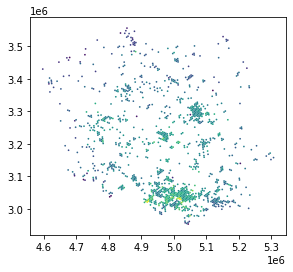

In [53]:
# join with grid
overlay = gpd.sjoin(left_df=gdf_data_winter_mean, right_df=df_grid, how="inner", op='within')
gdf_groupby = overlay.groupby('hex_id').mean()
gdf_groupby = gdf_groupby.reset_index()
gdf_groupby = gdf_groupby[['hex_id','pm25']]

grid_pm = pd.merge(df_grid, gdf_groupby, on='hex_id', how='left')
grid_pm.plot(column='pm25')
grid_pm

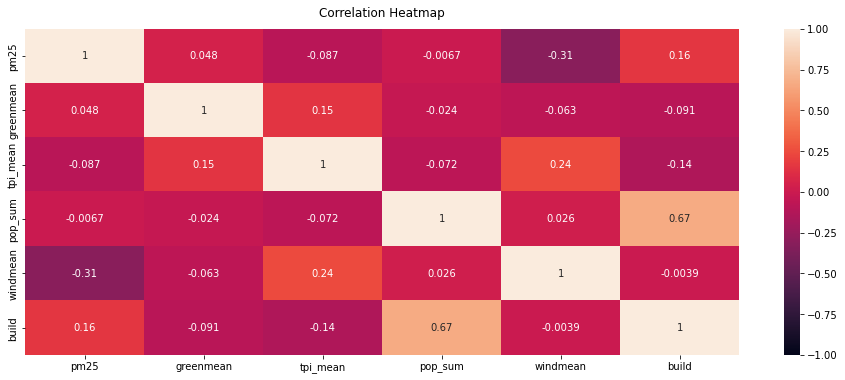

In [54]:
plt.figure(figsize=(16, 6))
features_corr = ['pm25', 'greenmean', 'tpi_mean', 'pop_sum', 'windmean', 'build']
heatmap = sns.heatmap(grid_pm[features_corr].corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
features = ['greenmean', 'tpi_mean', 'pop_sum', 'windmean', 'build']

# scaler = StandardScaler()
# scaler.fit(df_data_winter_joined[features])
# X_scaled = scaler.transform(df_data_winter_joined[features])

In [55]:
grid_model = grid_pm.dropna()

# gridsearch - to jest dla mnie bez sensu, bo wychodzi na test slabiej, na train tez:/
param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'],
                'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

rfr = RandomForestRegressor(random_state = 1)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid,
                        cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(grid_model[features], grid_model['pm25'])

# g_search.fit(X_train_ns, y_train_ns);
# model = RandomForestRegressor(g_search.best_params_)

# # Compute and print the metrics
# print(g_search.score(X_train_ns, y_train_ns))
# print(g_search.score(X_test_ns, y_test_ns))

model = RandomForestRegressor(n_estimators=200, random_state=0, max_depth=10)
model.fit(X_train_ns, y_train_ns)
print(model.score(X_train_ns, y_train_ns))
print(model.score(X_test_ns, y_test_ns))
grid_pm['predicted'] = model.predict(grid_pm[features])

0.6943467390195688
0.2331780526605316


Text(0.5, 1.0, 'predicted')

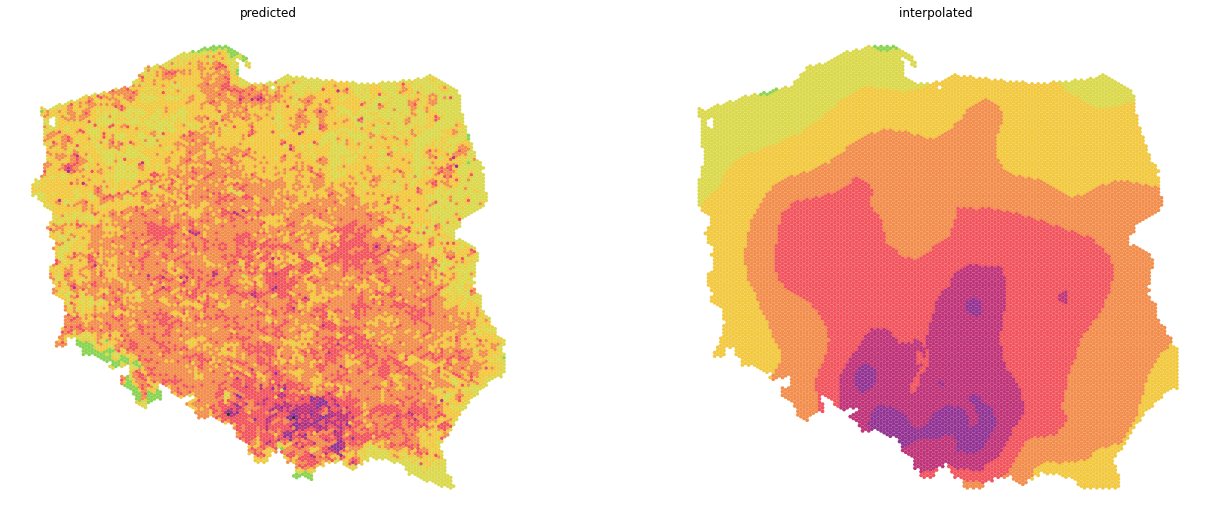

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,9))
levels_airly_caqi = [0, 15, 20, 25, 30, 35, 40, 50]
# levels_airly_caqi = [0, 10, 15, 20, 25, 30, 40, 50]
colors_airly_caqi = ['#6bc926', '#d1cf1e',  '#efbb0f', '#ef7120', '#EF2A36', '#B00057','#770078']

cmap_caqi, norm_caqi = matplotlib.colors.from_levels_and_colors(levels_airly_caqi, colors_airly_caqi)
grid_pm_pl = grid_pm.to_crs('epsg:2180')
grid_pm_pl.plot(ax=ax1, column='predicted', alpha=0.8, cmap=cmap_caqi, norm=norm_caqi, markersize=20)
grid_pm_pl.plot(ax=ax2, column='intmean', alpha=0.8, cmap=cmap_caqi, norm=norm_caqi, markersize=20)
ax2.axis("off")
ax1.axis("off")
ax2.set_title('interpolated ')
ax1.set_title('predicted')